# Description

This notebook works through a quick and easy video segmentation algorithm. Generally the steps can be described as:
1. IO/process video to frames
2. Compute frame to frame differences in pixels
    3. Compute some kind of time series model that predicts the expected differences in pixes.
    4. Find frames that differ significantly from predictions.
5. Construct a file with sample frame from each segment.


Note that this is a sample for one video. To implement at scale, consiering parallelizing this entire process.

# 1. Read in sample video: movie trailer for Before Midnight

In [1]:
# Nonstandard libraries
# ! pip install moviepy
# ! pip install pykalman
# ! pip install pytube (optional, if you want to d/l a video from youtube)
import pandas as pd, numpy as np, re, matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image,ImageStat
import imageio
from moviepy.editor import *

# For kalman filter model, can use any other time series model 
from pykalman import KalmanFilter
from scipy.linalg import block_diag
from numpy import ma


In [2]:
# Dynamic factor model functions
# Functions from my dynamic factor repository
def local_trend_component(p):
    return np.kron(np.triu(np.ones([2,2])), np.eye(p))
def seasonal_component(seasons, p):
    Ip = np.eye(p)
    x = np.kron(np.diag(np.ones(seasons-2), k = -1), Ip)
    y = np.kron(np.ones([1, seasons-1]), -Ip)
    x[:p, :] = y
    return x
def combine_components(listofcomponents):
    return block_diag(*listofcomponents)
# Specify n-poly dlm
def _poly_G_(n):
    x = np.eye(n)
    i,j = np.indices(x.shape)
    x[i==j-1] = 1
    return x
def _fourier_G_(s, q=2):
    if q == None:
        q = 2
    H = list()
    for r in range(1,q+1):
        omega = 2.*np.pi*r/s
        H.append([[np.cos(omega),np.sin(omega)],[-np.sin(omega), np.cos(omega)]])
    h0 = H[0]
    for h in H[1:]:
        h0 = block_diag(h0, h)
    return h0
def create_matrices(n=1,p=1,ndeg=1, s = 0, q = None):
    if q == None:
        q = 2
    if (s == 0)|(pd.isnull(s)):
        C = combine_components([np.kron(_poly_G_(ndeg), np.eye(n))])
        F = np.array([[1]+[0]*(ndeg-1)])
    if s != 0:
        C = combine_components([np.kron(_poly_G_(ndeg), np.eye(n)),
                               np.kron(_fourier_G_(s,q), np.eye(n))])
        F = np.array([[1]+[0]*(ndeg-1)+[1,0]*q])
    A=np.kron(F, np.eye(n))
    return C,A


In [3]:
if 1==0: # Download the youtube video if you want to
    import pytube
    # https://github.com/nficano/pytube/issues/467 # may need to patch pytube libary
    yt = pytube.YouTube('?v=Kv6JWoVKlGY')
    t = yt.streams.all()
    t[0].download(output_path="./")

In [4]:
# Read in video, note this video has been downsampled
# original video linked here: https://www.youtube.com/watch?v=Kv6JWoVKlGY
video = VideoFileClip("../Video/before_midnight.mp4") # moviepy lets you preview the video
vlen = video.end
print('Video size: {}x{}'.format(*video.size)+', {:.2f} secs'.format(vlen))

Video size: 256x144, 109.13 secs


In [5]:
video.ipython_display(maxduration = 300) # preview the video inline

chunk:   2%|█▍                                                            | 55/2407 [00:00<00:04, 546.00it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


t:  12%|███████▉                                                        | 325/2617 [00:00<00:00, 3226.42it/s, now=None]

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [6]:
# Get frames
# sample every frame 
video = video.resize(height=240)
sampled = [f for i,f in enumerate(video.iter_frames())]
print(len(sampled))
sampledt = np.array(range(len(sampled)))/len(sampled)*vlen

2617


# 2. Differences between frames

Text(0, 0.5, 'RSSE differences')

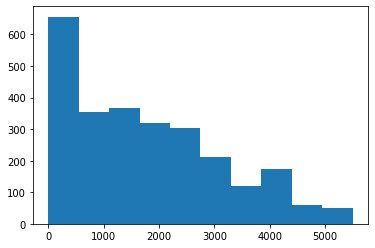

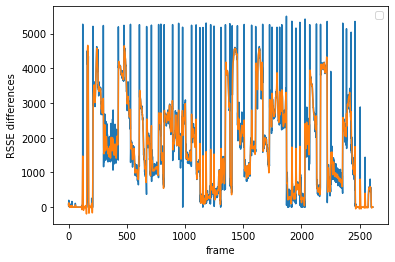

In [7]:
diff = [np.sqrt(np.square((f-sampled[i])).sum()) for i,f in enumerate(sampled[1:])] # Compute pixel differences

# Initiate DLM time series model, specify however you like
# This step uses a DLM w/ Kalman Filter, alternative approaches can be implemented as drop in functions
C,A=create_matrices(n=1,p=1,ndeg=5)
kf = KalmanFilter(transition_matrices = C, observation_matrices = A)
kf = kf.em(diff, n_iter=10) # Quick and dirty, not checking for convergence, doesn't really matter...
(filtered_state_means, filtered_state_covariances) = kf.filter(diff)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(diff)

# Plot the pixel diffs
plt.hist(diff)# Histogram of differences
plt.figure()
raw = plt.plot(diff) # Raw diffs
estimated = plt.plot(list(zip(*smoothed_state_means))[0]) # Model predicted diffs
plt.legend([raw,estimated], ['raw', 'estimated'])
plt.xlabel('frame')
plt.ylabel('RSSE differences')

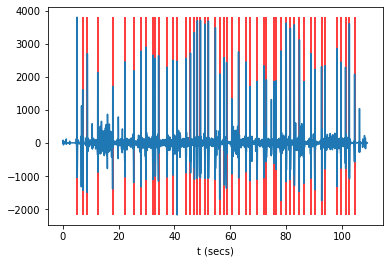

In [8]:
# Compute when there's large deviation from expected
DIFF = np.array(diff) - list(zip(*smoothed_state_means))[0] # Diff vs expected diff
variances_0 = [s[0][0] for s in smoothed_state_covariances]
# Scene change rule
chg_rule = 3

# Chg rule 1
# scenechange = [i for i,d in enumerate(DIFF) if d>chg_rule*variances_0[i]] # More than N times estimated variance

# Alternative rule
scenechange = [i for i,d in enumerate(DIFF) if d>chg_rule*np.std(DIFF)] # More than 3 standard deviations of time-series mean std.dev

# Time stamp of scene changes
scenechanget = sampledt[1:][scenechange]

# Plot in red where scenes change
plt.plot(sampledt[1:],DIFF)
plt.xlabel('t (secs)')
plt.vlines(scenechanget, min(DIFF), max(DIFF), color = 'red')

In [9]:
print('Scene changes: {}'.format(len(scenechange)))

Scene changes: 50


# 3. Visualize Segments

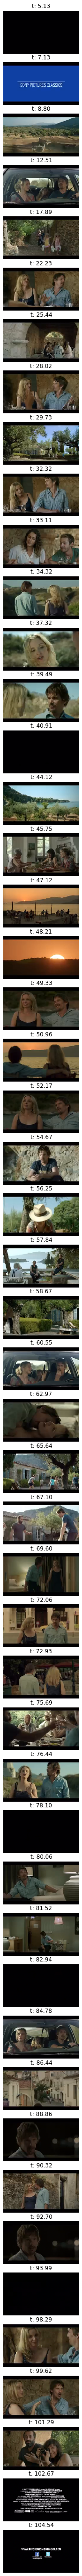

In [10]:
# Plot first frame of each scene 
fig, ax = plt.subplots(len(scenechange), figsize = (5, len(scenechange)*2))
for i,j in enumerate(scenechange):
    d = sampled[j+1]
    ax[i].imshow(d, interpolation = 'nearest')
    ax[i].set_title('t: {:.2f}'.format(scenechanget[i]))
    ax[i].axis('off')
fig.show()

In [11]:
def save_scenechgs(chgclips, fpath):
    new_clip = ImageSequenceClip(list(chgclips), fps = 1)
    new_clip.write_videofile(fpath)

In [12]:
# Save a 1 second per frame video of scene changes
scenes = np.array(sampled)[1:][scenechange]
save_scenechgs(scenes, '../Video/scenechgs.mp4')

Moviepy - Building video ../Video/scenechgs.mp4.
Moviepy - Writing video ../Video/scenechgs.mp4

Moviepy - Done !
Moviepy - video ready ../Video/scenechgs.mp4


In [13]:
video = VideoFileClip("../Video/scenechgs.mp4") # moviepy lets you preview the video
video.ipython_display(maxduration = 300) # preview the video inline

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4

Moviepy - Done !
Moviepy - video ready __temp__.mp4
